In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sounddevice as sd
from scipy.io import wavfile
from scipy import signal
from pydub import AudioSegment
import pandas as pd
from scipy.signal import butter, lfilter
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft

import warnings
warnings.filterwarnings('ignore')

my_seed = 146
np.random.seed(my_seed)

In [40]:
f = 'Alesis-Fusion-Bright-Acoustic-Piano-C4.wav'

samplerate, data = wavfile.read(f)
print('Sampling Rate:',samplerate)
print('Audio Shape:',np.shape(data))

Sampling Rate: 44100
Audio Shape: (130786, 2)


In [71]:
duration = len(data)/samplerate
time = np.arange(0, duration, 1/samplerate) #time vector
print(f"Длительность {duration}")
print(f"Временная шкала {time}")

Длительность 2.965668934240363
Временная шкала [0.00000000e+00 2.26757370e-05 4.53514739e-05 ... 2.96560091e+00
 2.96562358e+00 2.96564626e+00]


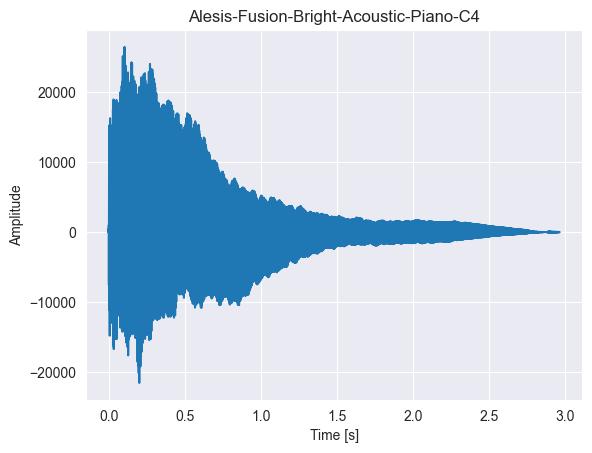

In [42]:
plt.plot(time, data[:, 0])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Alesis-Fusion-Bright-Acoustic-Piano-C4')
plt.show()

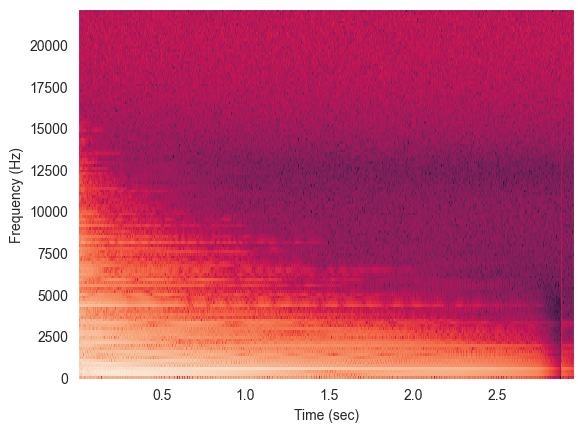

In [43]:
adata = data[:, 0]
s = samplerate
fr, tm, spgram = signal.spectrogram(adata,s)
lspg = np.log(spgram)
plt.pcolormesh(tm,fr,lspg,shading='auto')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
plt.show()

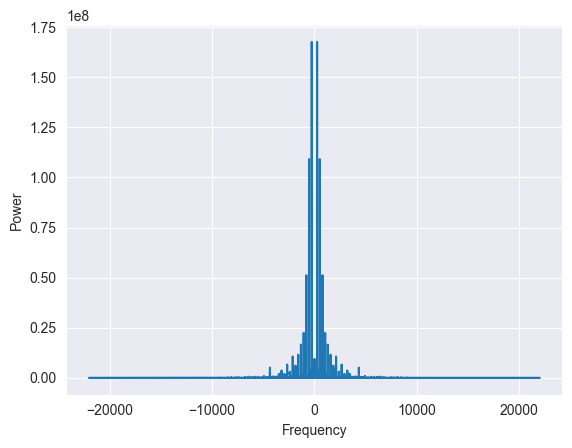

In [44]:
# число точек в normalized_tone
N = int(samplerate * duration)
yf = fft(data[:, 0])
xf = fftfreq(N, 1 / samplerate)
plt.plot(xf, np.abs(yf))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

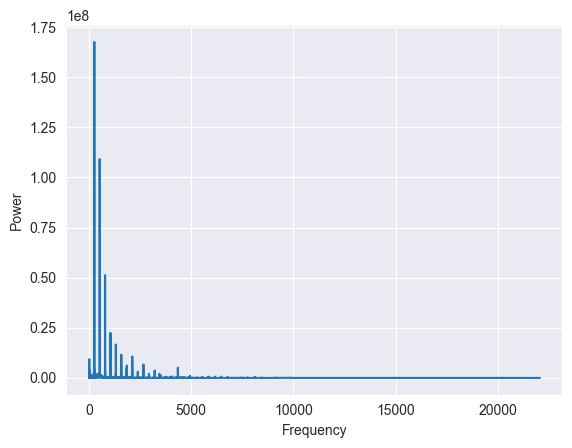

In [45]:
# число точек в normalized_tone
rN = int(samplerate * duration)
ryf = rfft(data[:, 0])
rxf = rfftfreq(rN, 1 / samplerate)
plt.plot(rxf, np.abs(ryf))
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

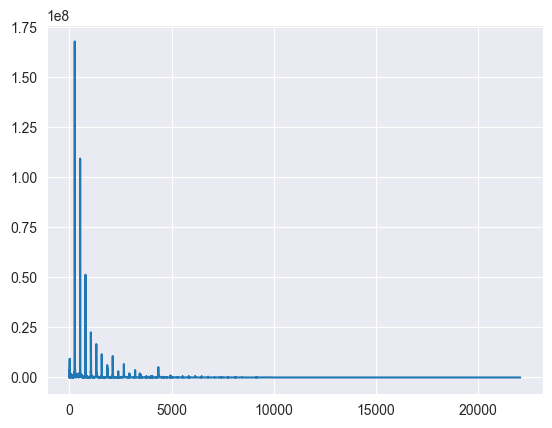

In [46]:
# Максимальная частота составляет половину частоты дискретизации
points_per_freq = len(rxf) / (samplerate / 2)
# Наша целевая частота
target_idx = int(points_per_freq * 4998.663426488456)
target_idx1 = int(points_per_freq * 10000)
ryf[target_idx-2:target_idx+2] = 0
plt.plot(rxf, np.abs(ryf))
plt.show()

In [60]:
points_per_freq = len(rxf) / (max(rxf))

# Наши целевые частоты 
target_idx_hf = int(points_per_freq * 800)
target_idx_lf = int(points_per_freq * 400)

ryf_hf = ryf.copy()
ryf_lf = ryf.copy()
ryf_bp = ryf.copy()
ryf_bp_rvs = ryf.copy()

ryf_hf[:target_idx_hf] = 0

ryf_lf[target_idx_lf:] = 0

ryf_bp[:target_idx_lf] = 0
ryf_bp[target_idx_hf:] = 0

ryf_bp_rvs = ryf_bp_rvs - ryf_bp.copy()

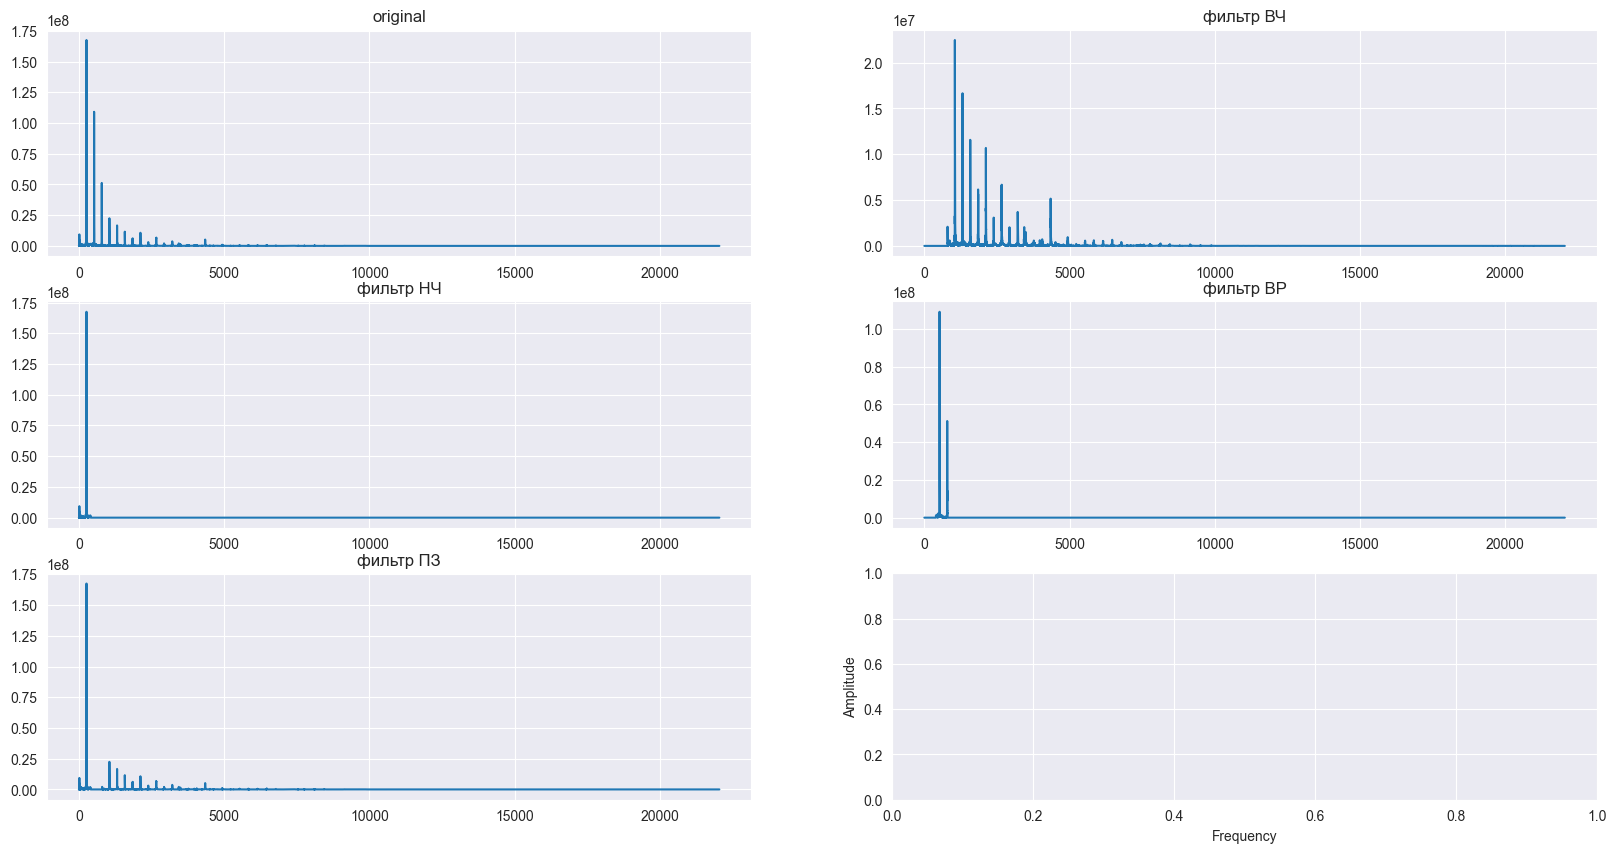

In [66]:
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize=(20, 10))

ax[0,0].plot(rxf, np.abs(ryf))
ax[0,0].set_title("original")

ax[0,1].plot(rxf, np.abs(ryf_hf))
ax[0,1].set_title("фильтр ВЧ")

ax[1,0].plot(rxf, np.abs(ryf_lf))
ax[1,0].set_title("фильтр НЧ")

ax[1,1].plot(rxf, np.abs(ryf_bp))
ax[1,1].set_title("фильтр BP")

ax[2,0].plot(rxf, np.abs(ryf_bp_rvs))
ax[2,0].set_title("фильтр ПЗ")


plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.show()

In [67]:
new_sig_hf = irfft(ryf_hf)
new_sig_lf = irfft(ryf_lf)
new_sig_bp = irfft(ryf_bp)
new_bp_rvs = irfft(ryf_bp_rvs)

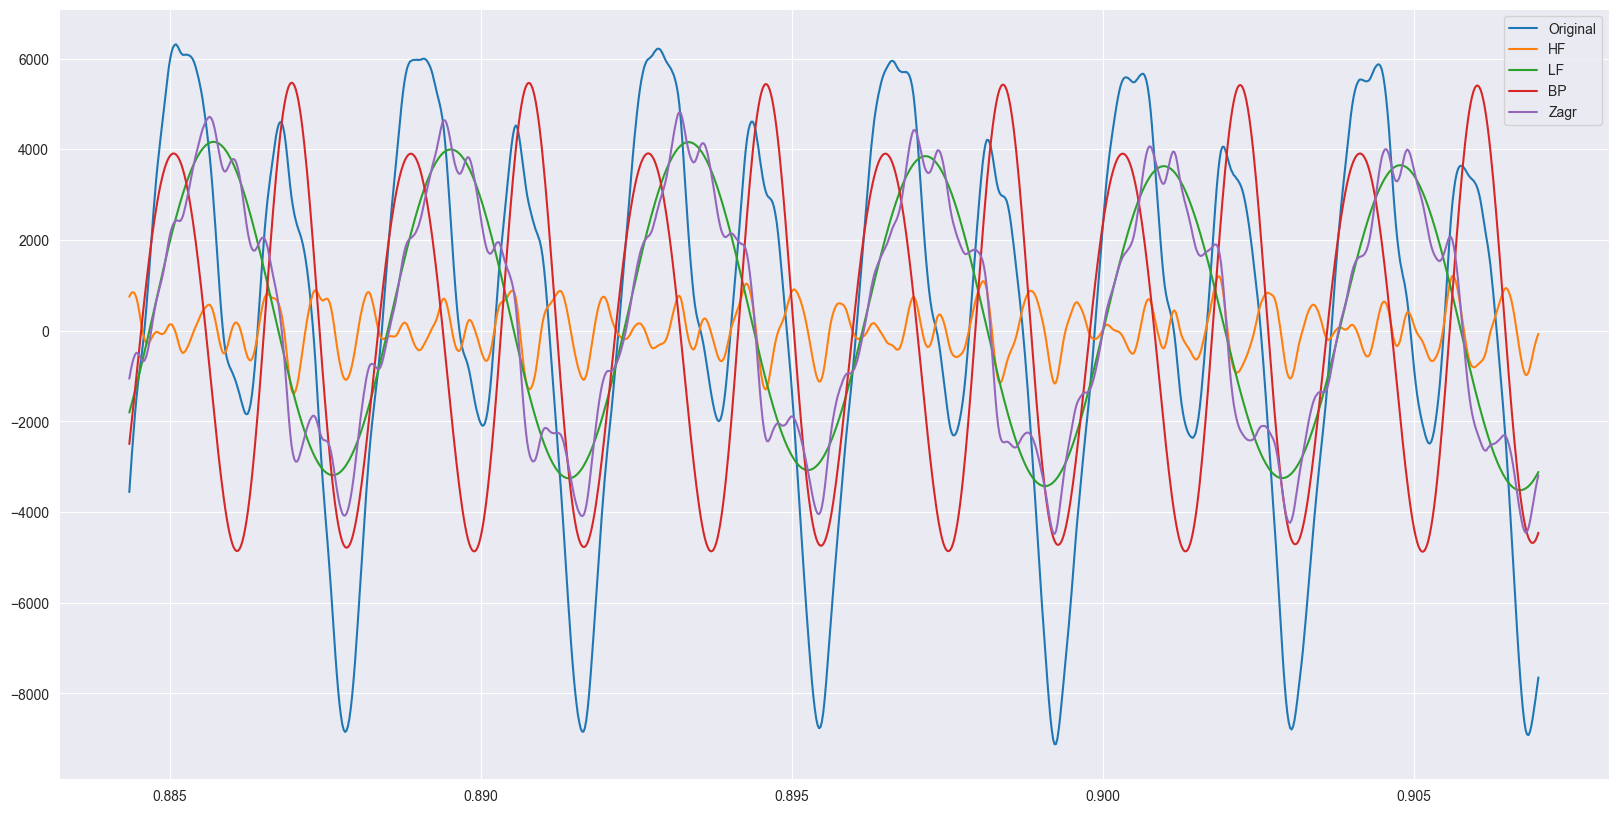

In [73]:
fig, ax = plt.subplots( figsize=(20, 10) )


original, = ax.plot(time[39000:40000], data[:, 0][39000:40000], label='Original')
signal_hf, = ax.plot(time[39000:40000], new_sig_hf[39000:40000], label='HF')
signal_lf, = ax.plot(time[39000:40000], new_sig_lf[39000:40000], label='LF')
signal_bp, = ax.plot(time[39000:40000], new_sig_bp[39000:40000], label='BP')
signal_bp_rvs, = ax.plot(time[39000:40000], new_bp_rvs[39000:40000], label='Zagr')


ax.legend(handles=[original, signal_hf, signal_lf, signal_bp, signal_bp_rvs])

plt.show()

In [77]:
def exponential_smoothing(values, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [values[0], values[1]]  # first value is same as series
    for n in range(1, len(values)):
        result.append(alpha * result[n] + (1 - alpha) * values[n-1])
    
    return result

def plot_exponential_smoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters

    """
    with plt.style.context("seaborn-v0_8-white"):
        plt.figure(figsize=(15, 7))
        plt.plot(series[1], "c", label="Actual")
        for alpha in alphas:
            plt.plot(exponential_smoothing(series[1], alpha), label="Alpha {}".format(alpha))
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Exponential Smoothing")
        plt.grid(True)

In [86]:
def double_exponential_smoothing(values, alpha, beta):
    result = [values[0]]
    for n in range(1, len(values)+1):
        if n == 1:
            level, trend = values[0], values[1] - values[0]
        if n >= len(values): # прогнозируем
            value = values[len(values)-1]
        else:
            value = values[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas

        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    with plt.style.context("seaborn-v0_8-white"):
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series[1], alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series[1], label = "Actual")
        plt.legend(loc="best")
        plt.axis("tight")
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

In [83]:
signal_part = data[:, 0][39000:40000]
time_part = time[39000:40000]
 
ts = pd.Series([time[39000:40000], data[:, 0][39000:40000]]) 

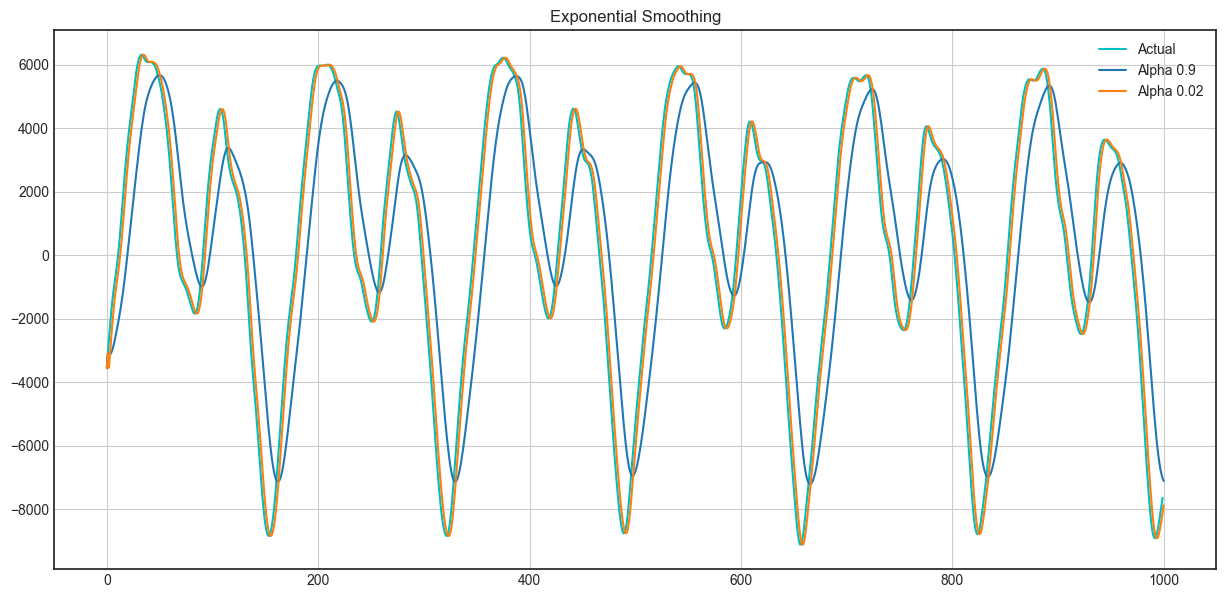

In [84]:
plot_exponential_smoothing(ts, [0.9, 0.02])

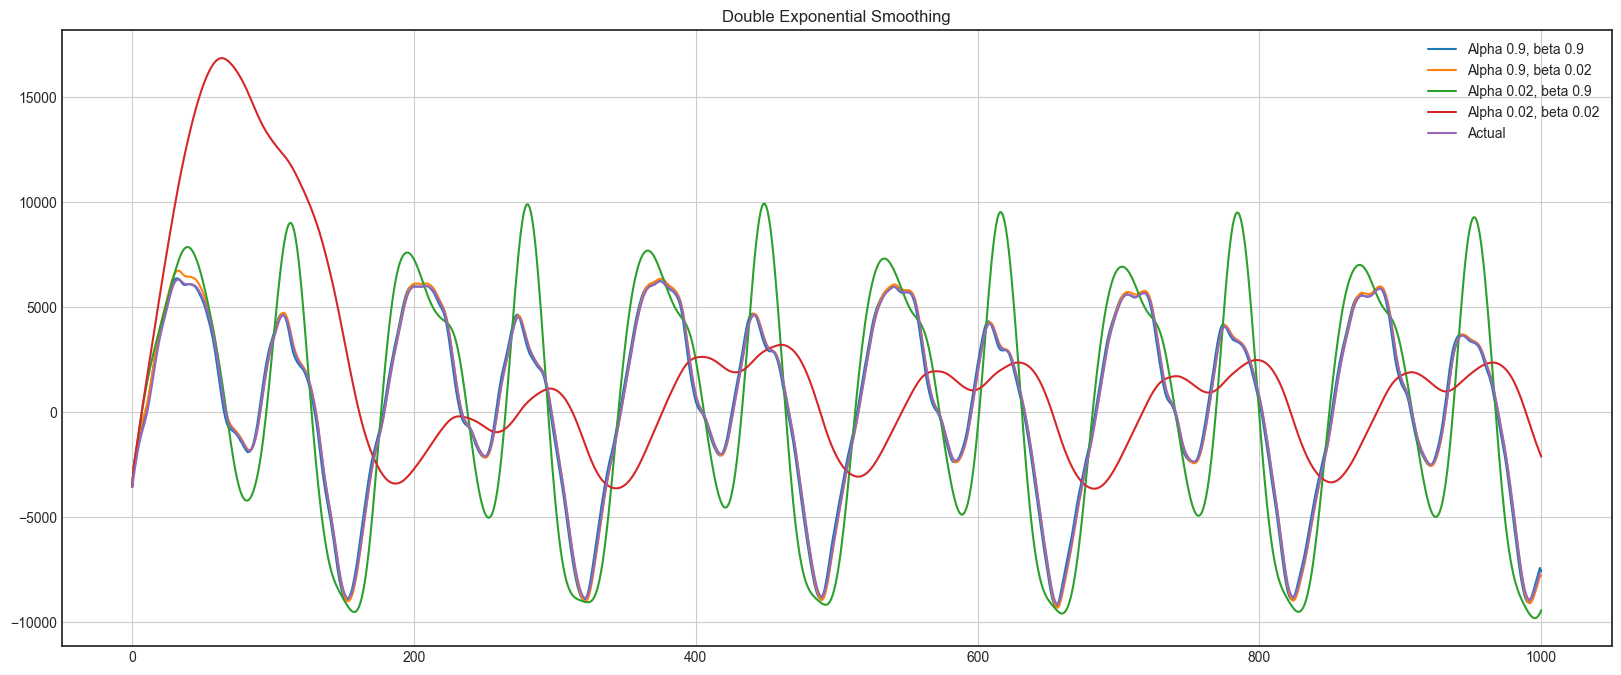

In [87]:
plot_double_exponential_smoothing(ts, [0.9, 0.02], [0.9, 0.02])

In [88]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series) / slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen * j:slen * j + slen]) / float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen * j + i] - season_averages[j]
        seasonals[i] = sum_of_vals_over_avg / n_seasons
    return seasonals

In [89]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

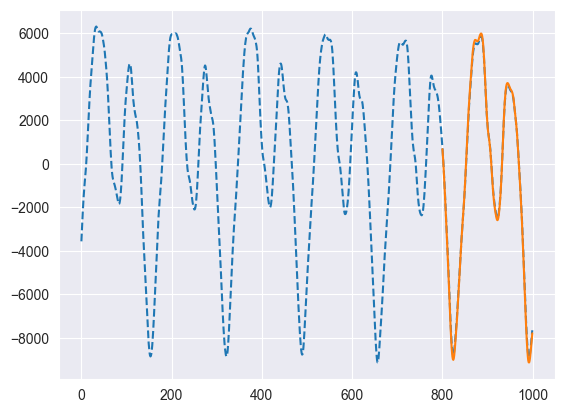

In [90]:
count = 200
ind = len(signal_part) - count
vals = triple_exponential_smoothing(signal_part, 12, 0.716, 0.029, 0.993, count)
# вырезаем отрезок по x, чтобы посмотреть
x = range(ind + count)
x_pr = range(ind, ind + count)
# отрисовываем. Сплошная линия - предсказание.
plt.plot(x[:], signal_part[:], linestyle='dashed')
plt.plot(x_pr, vals[ind:ind+count])

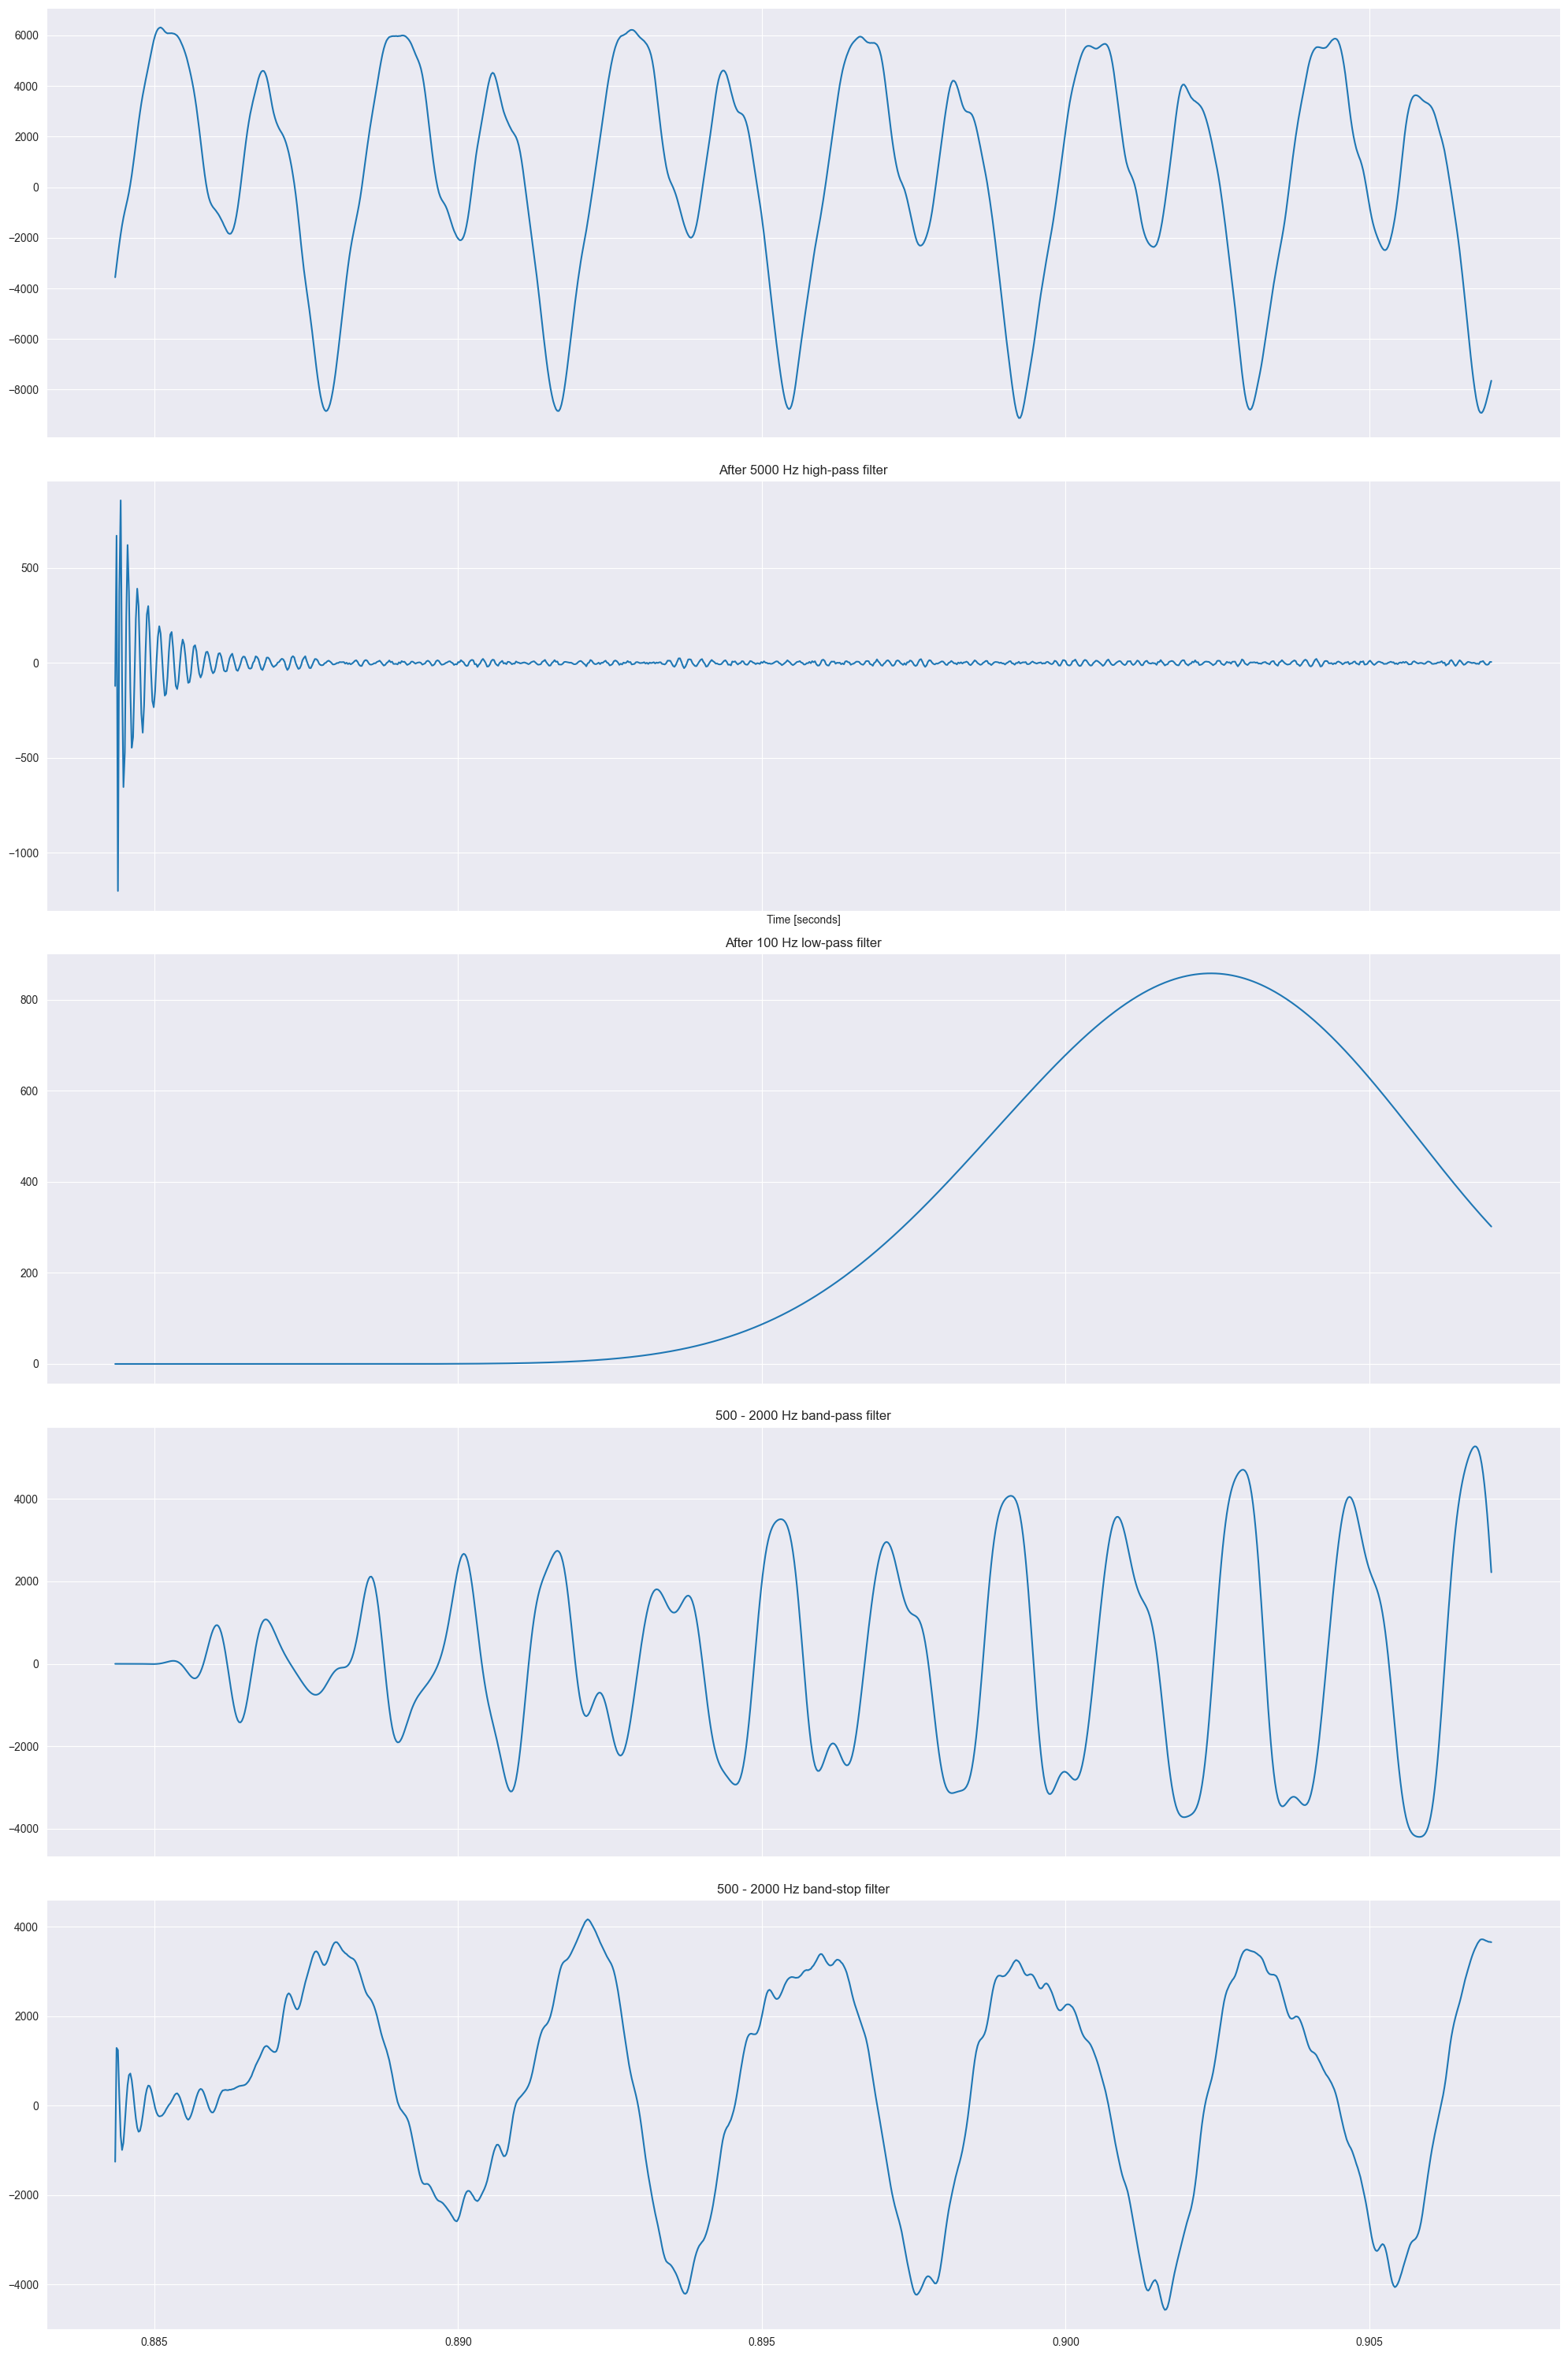

In [91]:
# high pass
sos_hp = signal.cheby1(10, 1, 5000, 'hp', fs=samplerate, output='sos')
filtered_hp = signal.sosfilt(sos_hp, signal_part)


# low pass
sos_lp = signal.cheby1(10, 1, 100, 'lp', fs=samplerate, output='sos')
filtered_lp = signal.sosfilt(sos_lp, signal_part)


# band pass
sos_bp = signal.cheby1(10, 1, [500, 2000], 'bp', fs=samplerate, output='sos')
filtered_bp = signal.sosfilt(sos_bp, signal_part)

# band pass
sos_bs = signal.cheby1(10, 1, [500, 2000], 'bs', fs=samplerate, output='sos')
filtered_bs = signal.sosfilt(sos_bs, signal_part)


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, sharex=True, figsize=(20,30))
ax1.plot(time_part, signal_part)

ax2.plot(time_part, filtered_hp)
ax2.set_title('After 5000 Hz high-pass filter')

ax3.plot(time_part, filtered_lp)
ax3.set_title('After 100 Hz low-pass filter')

ax4.plot(time_part, filtered_bp)
ax4.set_title('500 - 2000 Hz band-pass filter')
 
ax5.plot(time_part, filtered_bs)
ax5.set_title('500 - 2000 Hz band-stop filter')

ax2.set_xlabel('Time [seconds]')
plt.tight_layout()
plt.show()

In [ ]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

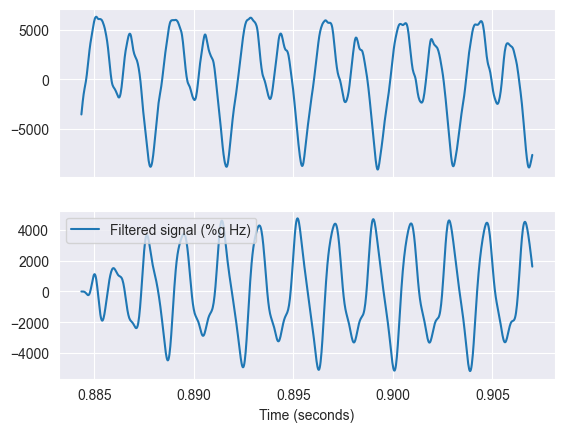

In [96]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = samplerate

lowcut = 500.0
highcut = 2000.0

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(time_part, signal_part, label='Noisy signal')

y = butter_bandpass_filter(signal_part, lowcut, highcut, fs, order=6)
ax2.plot(time_part, y, label='Filtered signal (%g Hz)')

plt.xlabel('Time (seconds)')
 
plt.grid(True)
plt.axis('tight')
plt.legend(loc='upper left')

plt.show()